In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
import warnings
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd

PATH = '/content/DATA 2020-2025.xlsx'
df = pd.read_excel(PATH)
df.head()

,TANGGAL,Prec
0,01-01-2020,14.0
1,02-01-2020,15.1
2,03-01-2020,2.7
3,04-01-2020,32.8
4,05-01-2020,3.7


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TANGGAL  1950 non-null   object 
 1   Prec     1950 non-null   float64
dtypes: float64(1), object(1)
memory usage: 30.6+ KB


In [ ]:
# Mengubah tipe data kolom 'Tanggal'
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format="%d-%m-%Y")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   TANGGAL  1950 non-null   datetime64[ns]
 1   Prec     1950 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 30.6 KB


In [ ]:
df.corr()

,TANGGAL,Prec
TANGGAL,1.000000,-0.012717
Prec,-0.012717,1.000000


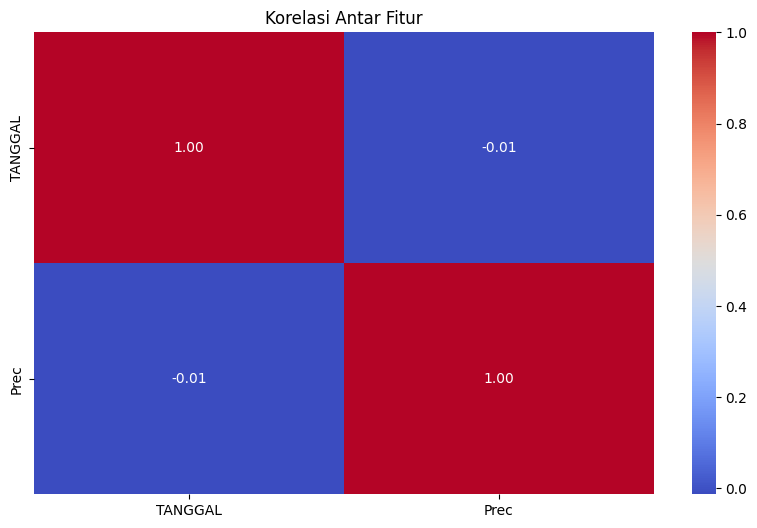

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Fitur")
plt.show()

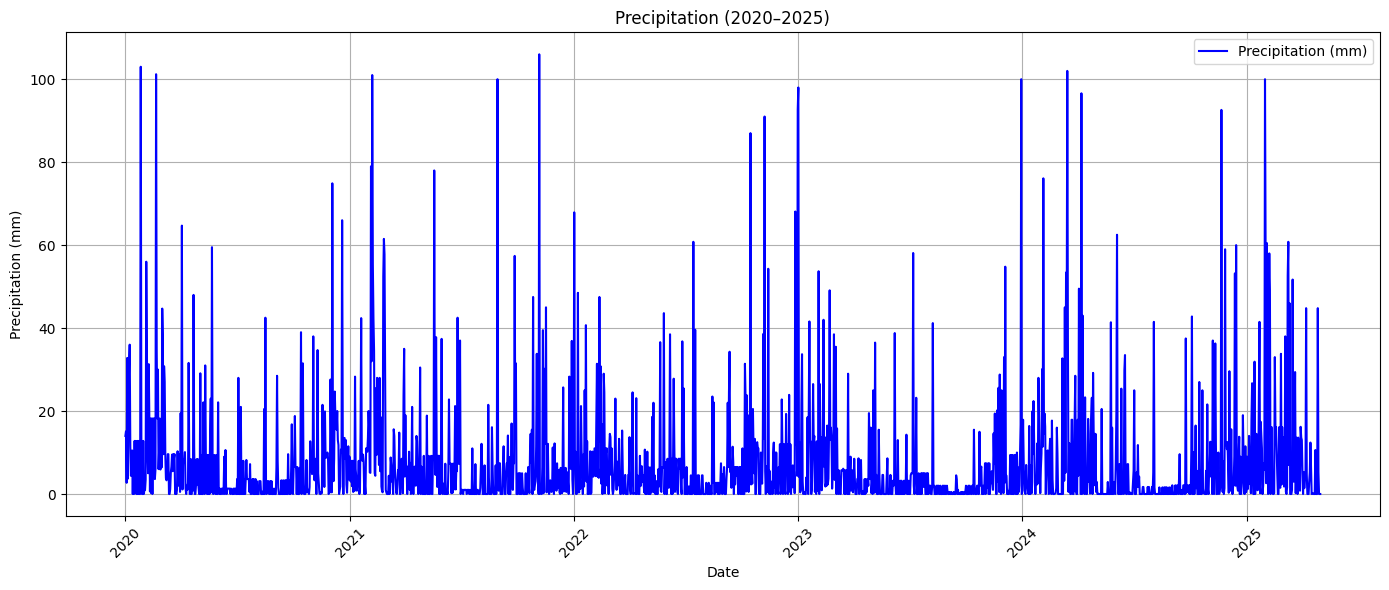

In [ ]:
# Plot data
plt.figure(figsize=(14, 6))
plt.plot(df['TANGGAL'], df['Prec'], label='Precipitation (mm)', color='blue')
plt.title('Precipitation (2020–2025)')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

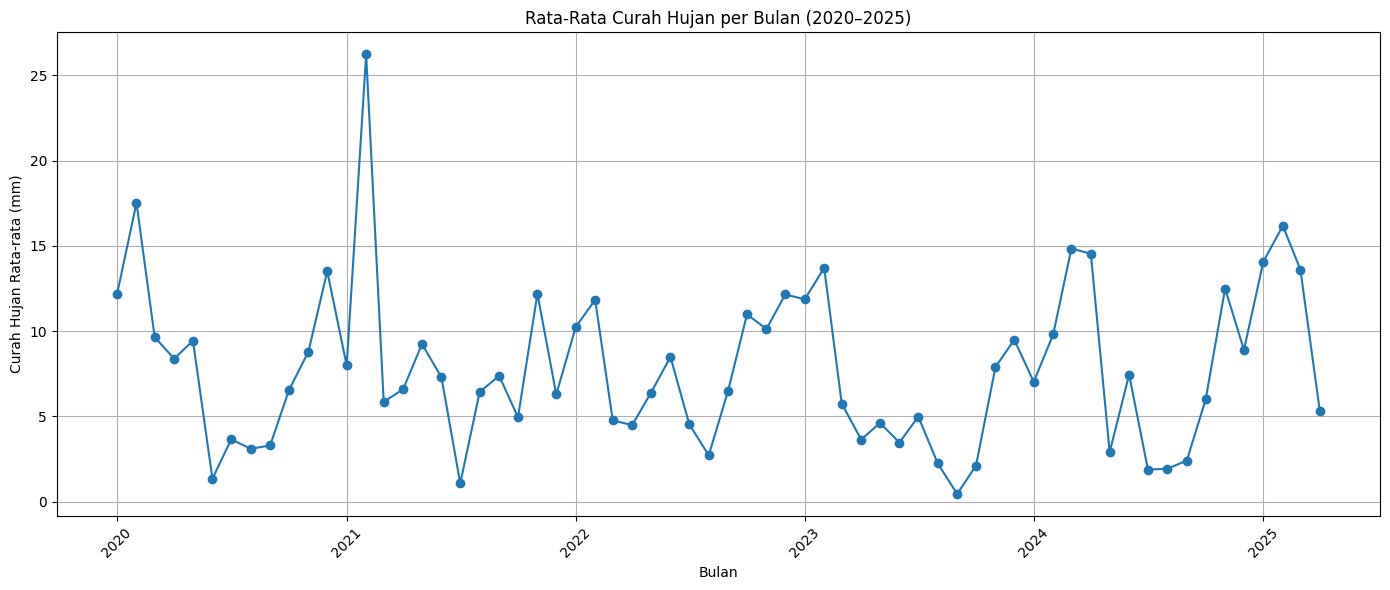

In [ ]:
# Ubah ke period bulanan terlebih dahulu
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'])  # pastikan kolom tanggal dalam datetime
df['TANGGAL'] = df['TANGGAL'].dt.to_period('M')

# Hitung rata-rata curah hujan per bulan
monthly_avg = df.groupby('TANGGAL')['Prec'].mean().reset_index()

# Kembalikan ke timestamp agar bisa diplot
monthly_avg['TANGGAL'] = monthly_avg['TANGGAL'].dt.to_timestamp()

# Plot hasil agregasi
plt.figure(figsize=(14, 6))
plt.plot(monthly_avg['TANGGAL'], monthly_avg['Prec'], marker='o', linestyle='-')
plt.title('Rata-Rata Curah Hujan per Bulan (2020–2025)')
plt.xlabel('Bulan')
plt.ylabel('Curah Hujan Rata-rata (mm)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Menghitung total baris
total_data = len(df)
# Menghitung jumlah nilai 'prec' yang 0.0
jumlah_nol = (df['Prec'] == 0.0).sum()
4
# Menghitung jumlah nilai 'prec' yang > 0.0
jumlah_lebih_nol = (df['Prec'] > 0.0).sum()
# Menghitung persentase
persentase_nol = (jumlah_nol / total_data) * 100
persentase_lebih_nol = (jumlah_lebih_nol / total_data) * 100
# Menampilkan hasil
print(f"Persentase nilai 'Prec' = 0.0: {persentase_nol:.2f}%")
print(f"Persentase nilai 'Prec' > 0.0: {persentase_lebih_nol:.2f}%")

Persentase nilai 'Prec' = 0.0: 31.23%
Persentase nilai 'Prec' > 0.0: 68.77%


In [ ]:
# Normalisasi data
training_data_length = math.ceil(len(df) * 0.8)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Prec']])

In [ ]:
# Pembagian dataset
train_data = scaled_data[0:training_data_length, :]
test_data = scaled_data[training_data_length - 60:, :]

In [ ]:
# Split data untuk x_train dan y_train
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

x_train shape: (1500, 60, 1)
y_train shape: (1500,)


In [ ]:
# Split data untuk x_test dan y_test
x_test = []
y_test = df[['Prec']][training_data_length:].values
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_test shape: (390, 60, 1)
y_test shape: (390, 1)


In [ ]:
train = df[:training_data_length]
valid = df[training_data_length:]

In [ ]:
# Membangun Model
model = Sequential()
model.add(LSTM(units=30, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size=16, epochs=400,
  validation_split=0.2)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
valid['Predictions'] = predictions



Epoch 1/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0211 - val_loss: 0.0150
Epoch 2/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0160 - val_loss: 0.0146
Epoch 3/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0171 - val_loss: 0.0145
Epoch 4/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0138 - val_loss: 0.0145
Epoch 5/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 6/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 7/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0136 - val_loss: 0.0142
Epoch 8/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0123 - val_loss: 0.0142
Epoch 9/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0176 - val_loss: 0.0142
Epoch 10/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0142 - val_loss: 0.0141
Epoch 11/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0144 - val_loss: 0.0141
Epoch 12/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

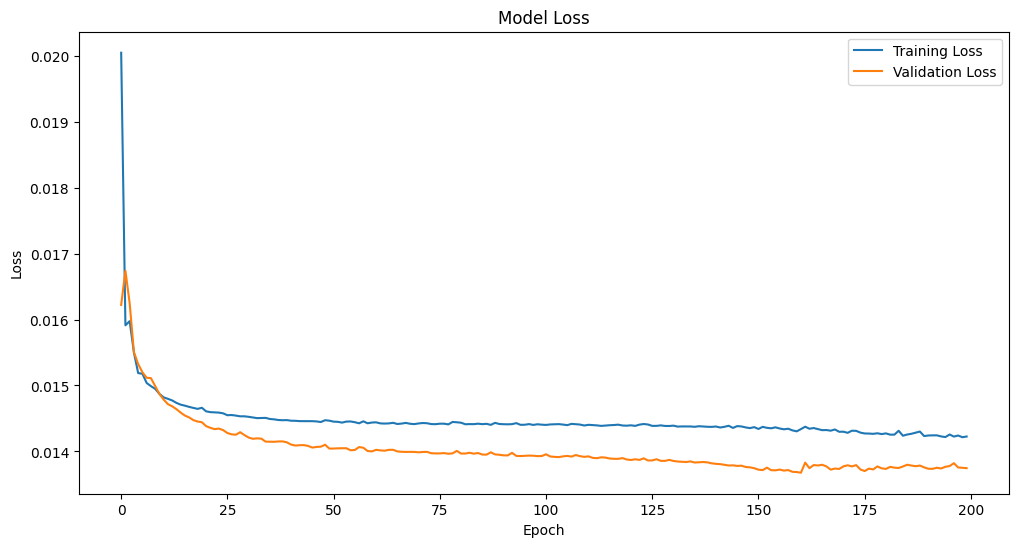

In [ ]:
# Visualisasi training dan validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

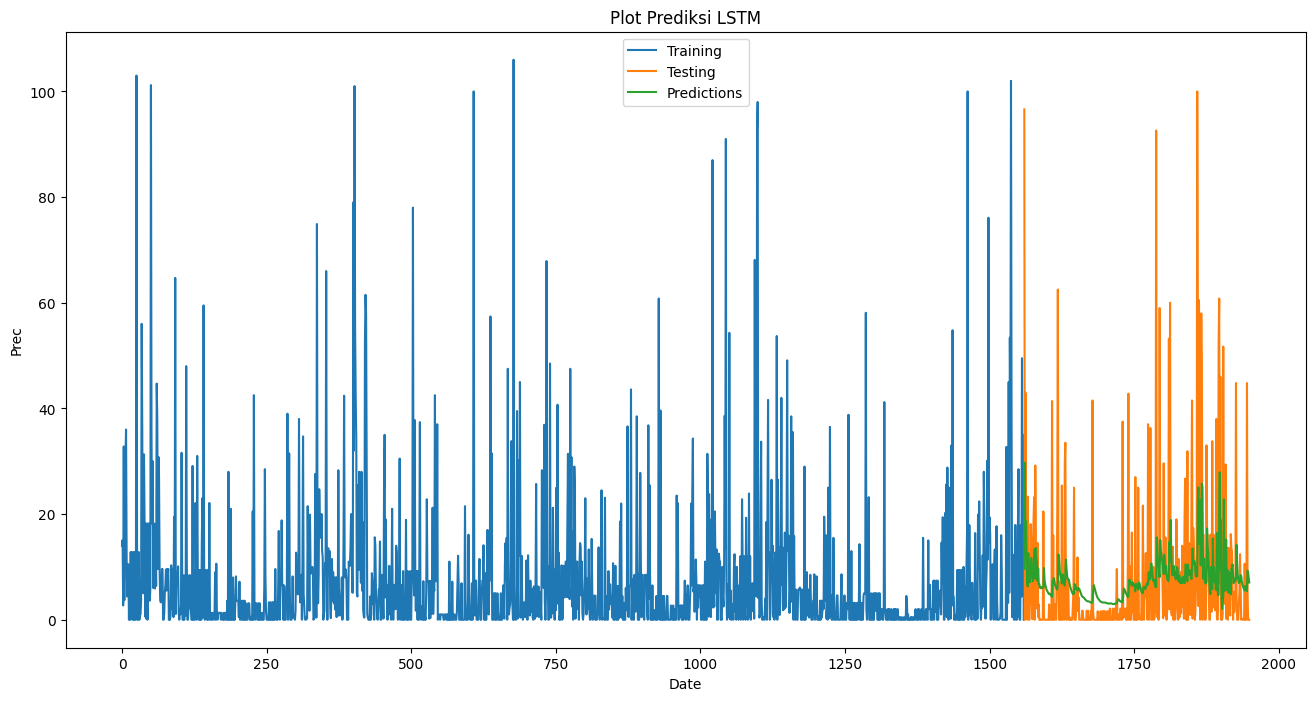

In [ ]:
# Visualisasi Prediksi
plt.figure(figsize=(16, 8))
plt.title('Plot Prediksi LSTM')
plt.xlabel('Date')
plt.ylabel('Prec')
plt.plot(train['Prec'], label='Training')
plt.plot(valid['Prec'], label='Testing')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend()
plt.show()

In [ ]:
# Menampilkan hasil prediksi dalam bentuk tabel
hasil_prediksi = valid[['Prec', 'Predictions']].copy()
hasil_prediksi = hasil_prediksi.rename(columns={
'Prec': 'Nilai Aktual',
'Predictions': 'Nilai Prediksi'
})
# Tampilkan beberapa baris teratas
print(hasil_prediksi.head)

<bound method NDFrame.head of       Nilai Aktual  Nilai Prediksi
1560          96.6        9.656404
1561           0.0       29.715580
1562          43.0       12.250380
1563           9.0       18.633287
1564           0.5       10.930677
...            ...             ...
1945          44.8        5.397798
1946           5.3        9.282341
1947           0.0        8.909483
1948           0.0        7.839619
1949           0.0        7.047862

[390 rows x 2 columns]>


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
valid = valid.dropna(subset=['Prec', 'Predictions'])
# Hitung metrik evaluasi
rmse = np.sqrt(mean_squared_error(valid['Prec'], valid['Predictions']))
mae = mean_absolute_error(valid['Prec'], valid['Predictions'])
mape = np.mean(np.abs((valid['Prec'] - valid['Predictions']) / valid['Prec'].replace(0, np.nan))) * 100

# Cetak hasil evaluasi
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 14.83
MAE: 9.15
MAPE: 560.59%
